[15- Convolutional Neural Networks Explained Easily](https://www.youtube.com/watch?v=t3qWfUYJEYU&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=16)

[16- How to Implement a CNN for Music Genre Classification](https://www.youtube.com/watch?v=dOG-HxpbMSw)

# CNNs ~ Convolutional Neural Networks
- Mainly used for processing images
- Perform better than multilayer perceptron
- Less parameters than dense layers
- Components
  - Convolution
  - Pooling

### Intuition
- Image data is structured
  - Edges, shapes
  - Translation invariance
  - Scale invariance
- CNN emulates human vision system
- Components of a CNN learn to extract different features



### Convolution
- Kernel = grid of weights
- Kernel is "applied" to the image
- Traditionally used in image processing

Ex. A grey scale image and each pixel has a different value from 0-255 (weight)

Each output = dot product between pixel and surrounding pixels in the image and the kernel


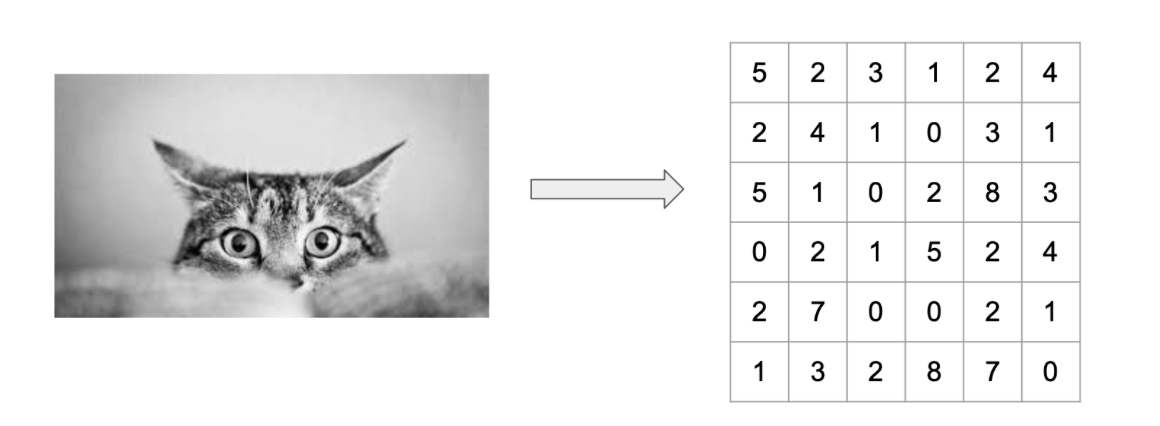

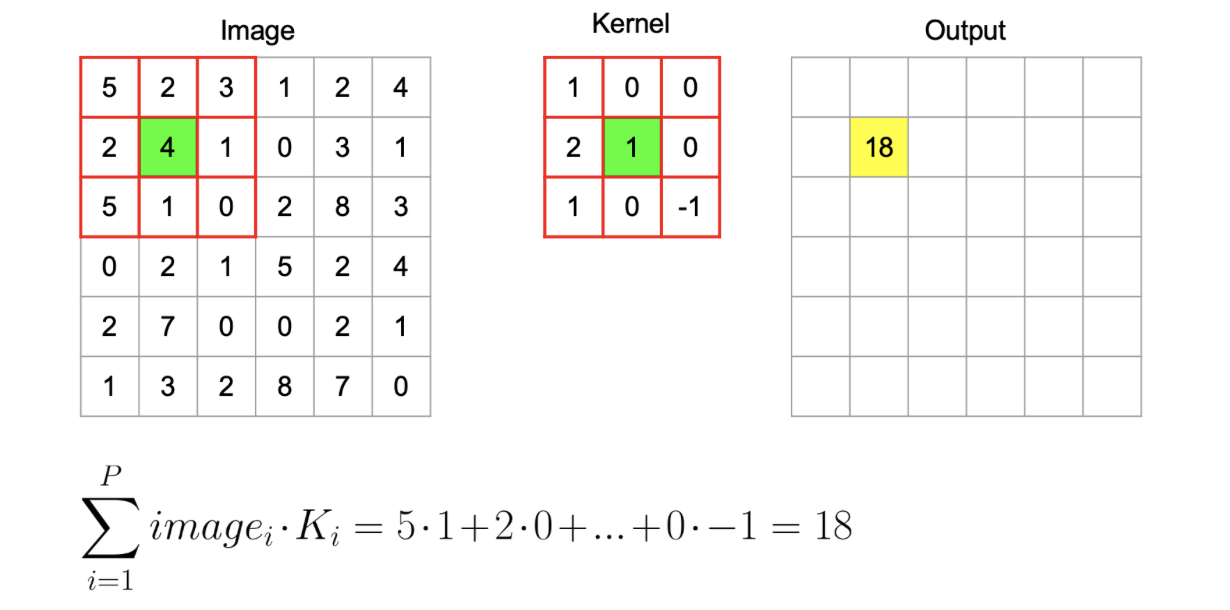

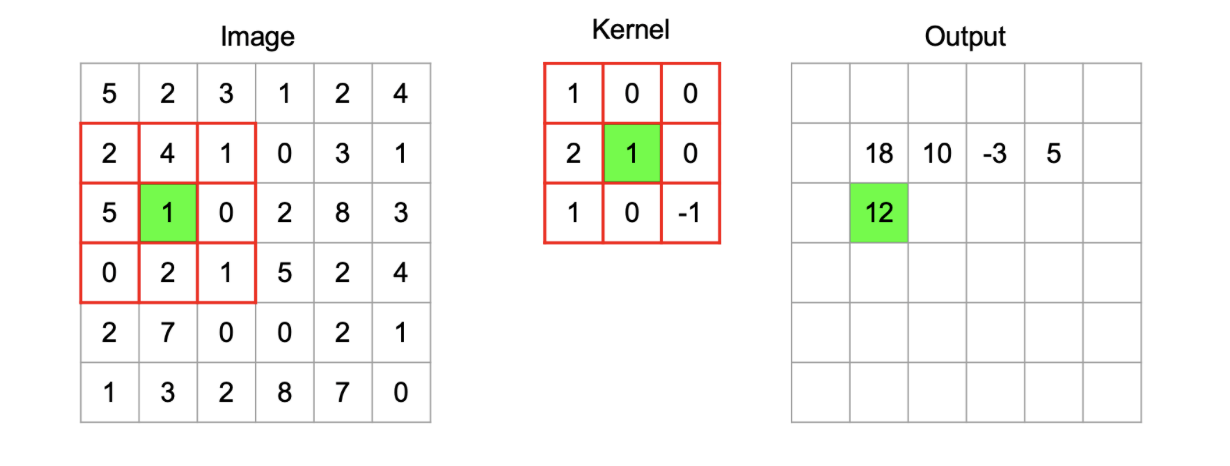

### Convolution: Zero Padding
Zero padding deals with the outside of an image becasue on the ouside weights (such as top left's 5), there are no numbers surrounding it. Zero padding makes it so that the dot product will use a 0 instead.

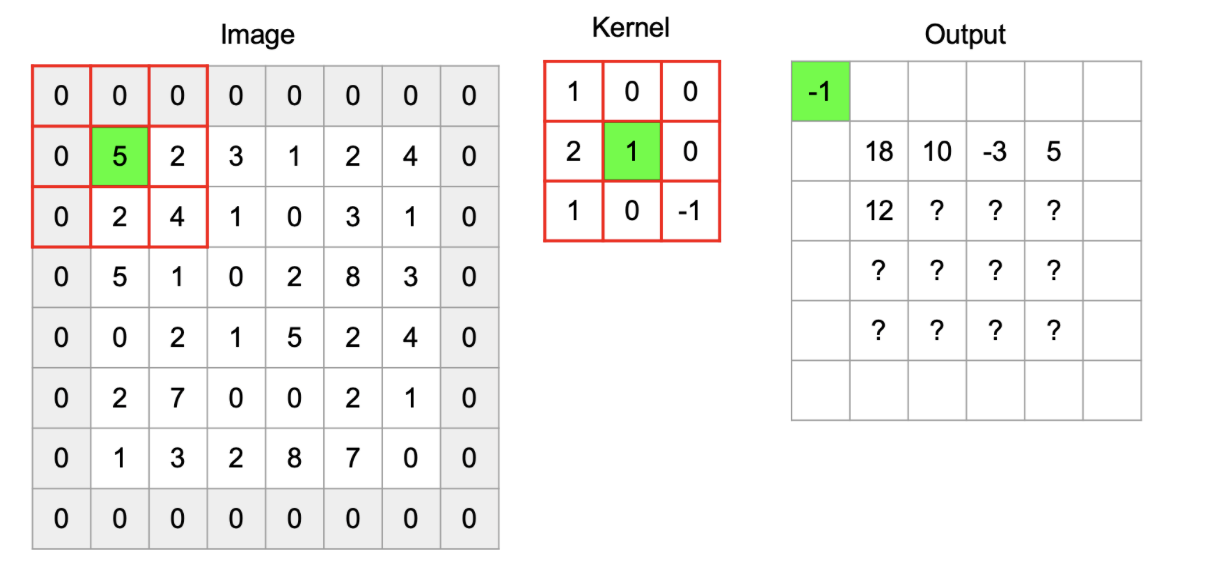

### Kernels
- Feature detectors
- Kernels are learned

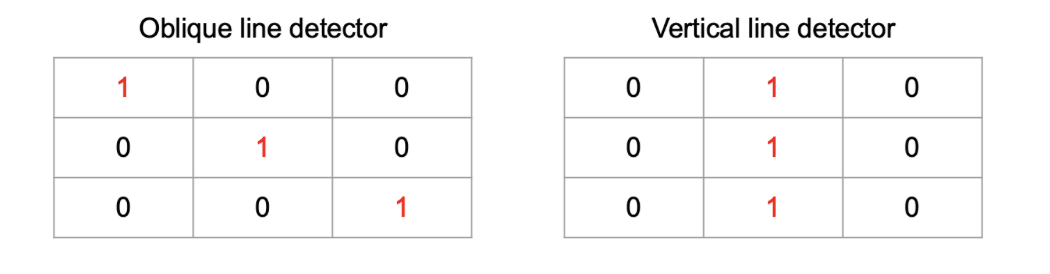

### Architectural decisions for convolution
- Grid size
  - Number of pixels for height/width
  - Odd numbers
- Stride
  - Step size used for sliding kernel on image
  - Indicated in pixels
- Depth
  - 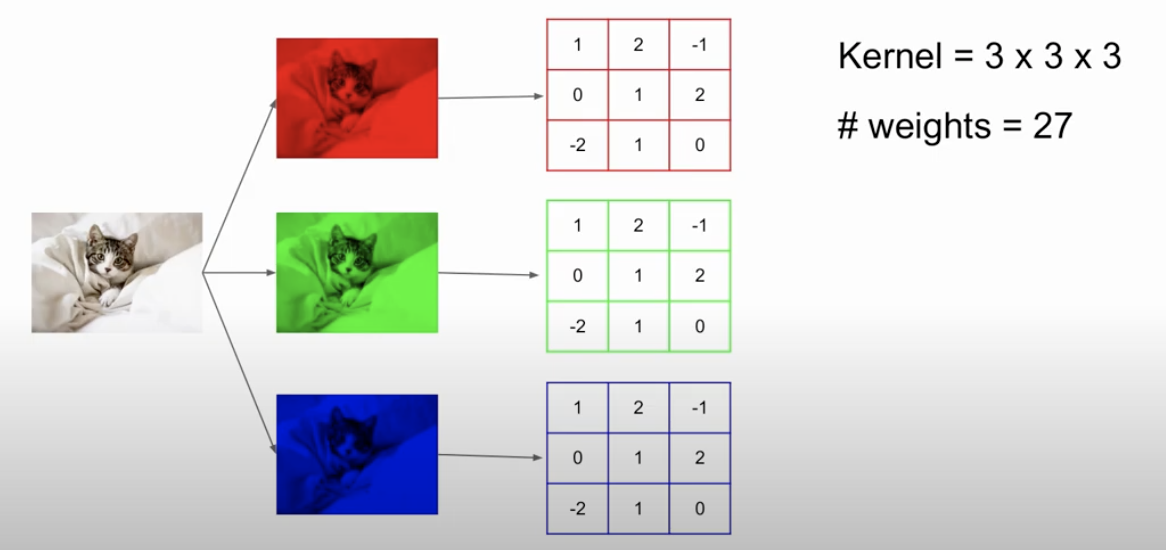
- Number of kernels
  - A conv layer has multiple kernels
  - Each kernel outputs a single 2D array
  - Output from a layer has as many 2D arrays as num of kernels

### Pooling
- Downsample the image
- Overlaying grid on image
- Max/Average pooling
- No parameters

##### Pooling settings
- Grid size
- Stride
- Type (e.g. max, average)

Max pooling example below, grabs the largest number in each 2x2 block.

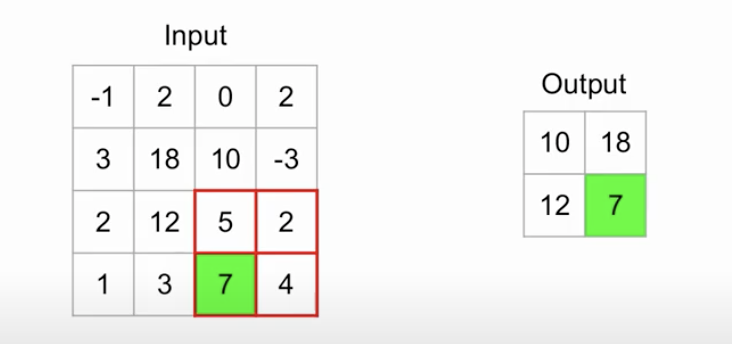




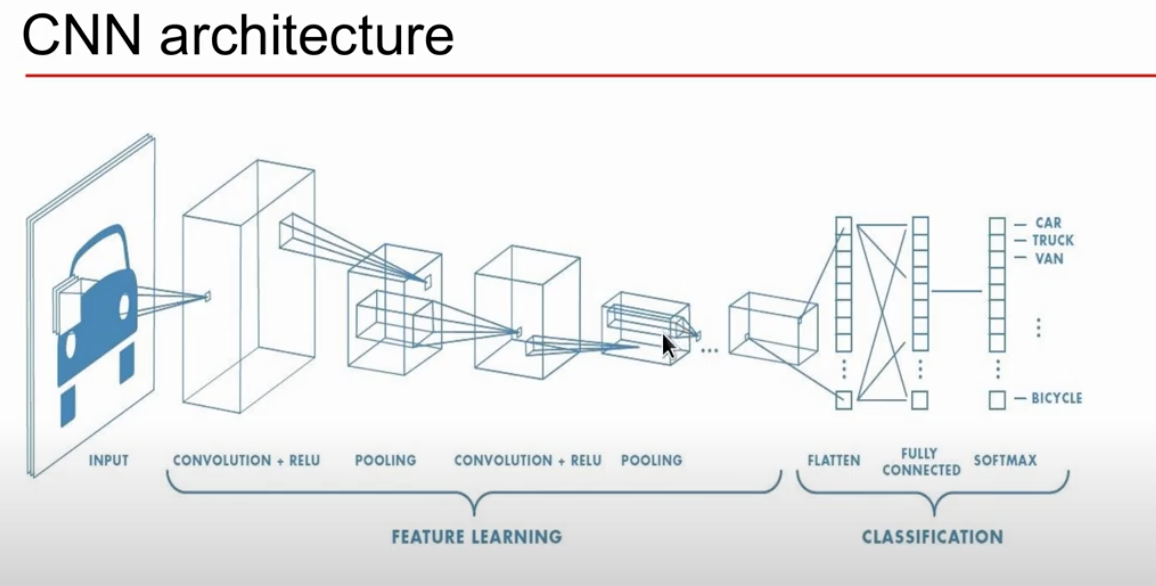

Going to use the generated spectogram and MFCC as the image to apply the convolution and pooling.

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# to mount to my personal google drive that conatins data_extract_music.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path to json file that stores MFCCs and genre labels for each processed segment
# same json from vid 13
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data_extract_music.json"

In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets ~ 3d array -> (..., ..., ...) -> 130, 13, 1
    X_train = X_train[..., np.newaxis] # 4d array (num_samples, ..., ..., ... ) -> (num_samples, 130, 13, 1 )
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    # padding=same is the zero padding
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    # changed the kernel from (3, 3) to (2, 2)
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

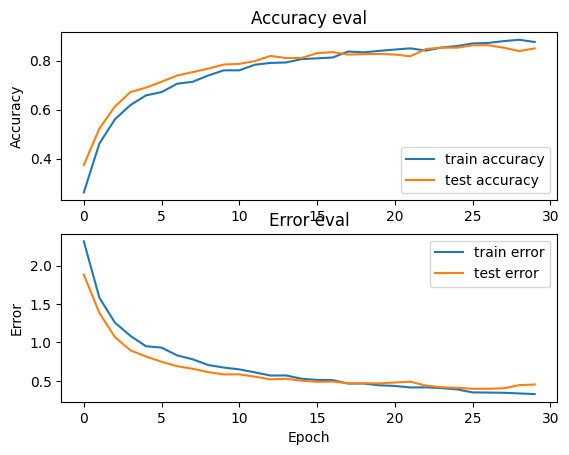

38/38 - 1s - loss: 0.4557 - accuracy: 0.8332 - 538ms/epoch - 14ms/step

Test accuracy: 0.8331929445266724
1/1 [==============================] - 0s 139ms/step
Target: 5, Predicted label: [5]


In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_validation, y_validation), 
                        batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)
